# Online learining tutorial
This tutorial shows how deploy a model for tabular data classification. With a possibility to retrain it when new data gets added to the dataset, while keeping predictor model available to make classifications.

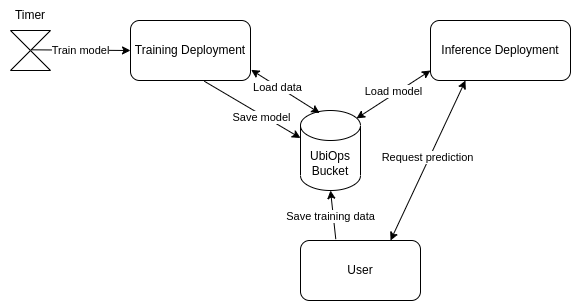

In [417]:
from IPython import display
display.Image("ubiops.png")

## Connect to UbiOps API
Python API is the most preferable way to interract with UbiOps, because library for it is autogenerated and it also allows to automate deployment tasks. However CLI commands and UI on the platform are also available.

In [1]:
import ubiops
# You should put your token in the ./token.txt
api_token = open('./token.txt').read().strip('\n')
project_name = 'newerproject'
client = ubiops.ApiClient(ubiops.Configuration(api_key={"Authorization": api_token}))
api = ubiops.CoreApi(client)
api.service_status()

{'status': 'ok'}

## Creating folder on UbiOps for persistent storage
List of all available requests to the system: https://github.com/UbiOps/client-library-python

In [2]:
# Can't because of free subscription
# data = ubiops.BucketCreate(name="rainydata", provider="ubiops")
# api.buckets_create(project_name, data)

api_response = api.buckets_get(project_name, 'default')
print(api_response)

{'configuration': {},
 'creation_date': datetime.datetime(2023, 8, 4, 19, 5, 5, 152716, tzinfo=tzutc()),
 'description': '',
 'id': '5f27193f-d40e-4b62-ad87-05bb1ff4cccf',
 'labels': {},
 'last_updated': datetime.datetime(2023, 8, 4, 19, 5, 5, 152728, tzinfo=tzutc()),
 'name': 'default',
 'project': 'newerproject',
 'provider': 'ubiops',
 'size': 0,
 'size_measurement_date': datetime.datetime(2023, 8, 5, 2, 23, 24, 670551, tzinfo=tzutc()),
 'ttl': None}


## Get and upload the dataset

I will use dataset Rain in Australia from Kaggle to train my model. The goal of this dataset is to train a classifier that will predict is it going to rain or not next day in Australia. Dataset itself has data about 145,000 days.
Dataset: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

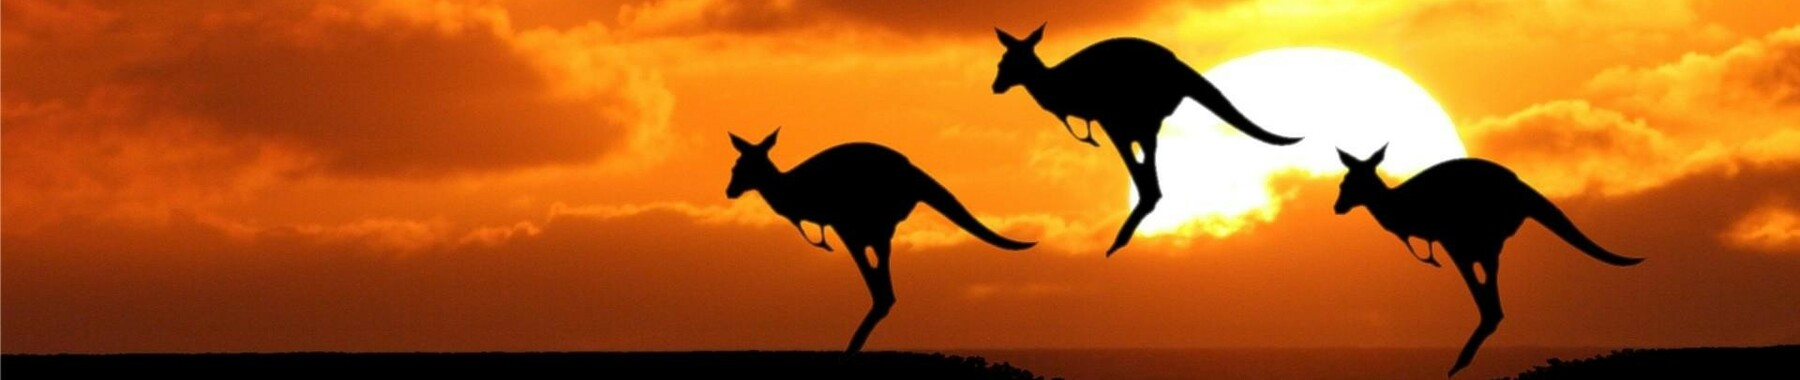

In [418]:
from IPython import display
display.Image("dataset-cover.jpg")

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('weatherAUS.csv').sort_values('Date')
# I will split data into multiple batches that were collected in different moments of time
batches = np.array_split(data, 6)
to_predict = batches[-1]
batches = batches[:-1]
batches[0].head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


## Upload data to a bucket
This 2 requests can be used later by your microservice to upload data batches as soon as they are collected.

In [4]:
import requests
resp = api.files_upload(project_name, 'default', 'data/batch1.csv', data={})
requests.put(resp.url, data=batches[0].to_csv(index=False))

<Response [200]>

## Create new services user 
Deployments will need a user token that has permissions to access default bucket.

In [5]:
data = ubiops.ServiceUserCreate()
users = api.service_users_list(project_name)

api_response = api.service_users_create(project_name, data)
service_user_token = api_response.token

In [6]:
service_user_token

'e1ee0990f2358b3694c74edd53707e971b1bb81d'

## Create notification group
All emails in this group will be notified when new model version gets trained

In [8]:
data = ubiops.NotificationGroupCreate(name='training-informed-1', 
                                      contacts=[
                                          {'type':'email', 'configuration': {'email_address': 'magisterbrownie@gmail.com'}}
                                      ])
api_response = api.notification_groups_create(project_name, data)
notification_group_name = api_response.name

## Create deployment for training

In [9]:
# Initialize deployment that will train model and save it in the bucket
deployment_name = 'weather-training'
deployment_template = ubiops.DeploymentCreate(
    name=deployment_name,
    description='Training model for weather prediction',
    input_type='structured',
    output_type='structured',
    input_fields=[],
    output_fields=[
        {'name':'output_file', 'data_type':'file'}
    ],
    labels={'demo': deployment_name}
)

api.deployments_create(
    project_name=project_name,
    data=deployment_template,
)

# Add token of the user that we created earlier to acess UbiOps bucket from deployment
data = ubiops.EnvironmentVariableCreate( name='UBIOPS_API_TOKEN', value=service_user_token, secret=True)
api.deployment_environment_variables_create(project_name, 
                                            deployment_name, 
                                            data=data)

{'id': '7647353b-c632-45c9-9e39-d7689fbaed74',
 'name': 'UBIOPS_API_TOKEN',
 'secret': True,
 'value': None}

## Model that will be trained
This is a code that will initialize model inside deployment. It creates scikit-learn pipeline that first preprocesses dataset and then applies Random Forest Classifier to it.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

one_hot = ['RainToday','WindGustDir','WindDir9am','WindDir3pm']
lable = ['Location']
nan_columns = ['Cloud3pm','Cloud9am','Evaporation','Humidity3pm','Humidity9am','MaxTemp','MinTemp','Pressure3pm','Pressure9am','Rainfall','Sunshine','Temp3pm','Temp9am','WindGustSpeed','WindSpeed3pm','WindSpeed9am']
ct = ColumnTransformer(
[("one_hot_encoder", OneHotEncoder(), one_hot),
("lable_encoder", OrdinalEncoder(), lable),
 ("nans",SimpleImputer(add_indicator=True),list(nan_columns))
], remainder='passthrough',verbose_feature_names_out=False)

selector = ColumnTransformer([('select', ct, make_column_selector(pattern=f'^(?!Date)'))],verbose_feature_names_out=False)

pipe = Pipeline([
    ('preporcess',ColumnTransformer([('select', ct, make_column_selector(pattern=f'^(?!Date)'))],verbose_feature_names_out=False)), 
    ('classify',  RandomForestClassifier( random_state=14, n_jobs=-1))
])
pipe

Pipeline(steps=[('preporcess',
                 ColumnTransformer(transformers=[('select',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('one_hot_encoder',
                                                                                   OneHotEncoder(),
                                                                                   ['RainToday',
                                                                                    'WindGustDir',
                                                                                    'WindDir9am',
                                                                                    'WindDir3pm']),
                                                                                  ('lable_encoder',
                                                                                   OrdinalEncoder(),
                                                                                   ['Location']),
                                                                                  ('nans',
                                                                                   SimpleImputer(add_indicator=True),
                                                                                   ['Cloud3pm',
                                                                                    'Cloud9am',
                                                                                    'Evaporation',
                                                                                    'Humi...
                                                                                    'MaxTemp',
                                                                                    'MinTemp',
                                                                                    'Pressure3pm',
                                                                                    'Pressure9am',
                                                                                    'Rainfall',
                                                                                    'Sunshine',
                                                                                    'Temp3pm',
                                                                                    'Temp9am',
                                                                                    'WindGustSpeed',
                                                                                    'WindSpeed3pm',
                                                                                    'WindSpeed9am'])],
                                                                    verbose_feature_names_out=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07981061d0>)],
                                   verbose_feature_names_out=False)),
                ('classify',
                 RandomForestClassifier(n_jobs=-1, random_state=14))])

## Deployment version file
Finally we will create a deployment version file that will load all csvs from the bucket and combine them into one dataset. Then it will train a model using that dataset and save result in a pickle format.

In [11]:
%mkdir training_instance

mkdir: cannot create directory ‘training_instance’: File exists


In [12]:
%%writefile training_instance/requirements.txt
pandas
scikit-learn
ubiops

Overwriting training_instance/requirements.txt


In [14]:
%%writefile training_instance/deployment.py

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import pickle
import ubiops

class NoDataError(Exception):

    def __init__(self, public_error_message):
        super().__init__()
        self.public_error_message = public_error_message

class Deployment:

    def __init__(self, base_directory, context):
        print("Initialising weather training")
        self.project = context['project']
        self.bucket = 'default'
        self.data_path = 'data'
        self.save_model_path = 'model.pkl'

    def request(self, data):
        core_api = ubiops.CoreApi()
        resp = core_api.files_list(self.project, self.bucket, prefix=self.data_path)
        
        # Check that there is at least single batch of data present
        if len(resp.files)<=0:
            raise NoDataError(public_error_message=f'Path: "{self.data_path}" in a Bucket: "{self.bucket}" does not have any files')
        
        # Read all files from the folder
        links = map(lambda x:core_api.files_download(self.project, self.bucket, x.file).url, resp.files)
        df = pd.concat(map(pd.read_csv, links))
        core_api.api_client.close()
     
        # Split dataset into lables and features
        df = df[~df['RainTomorrow'].isna()]
        y = df['RainTomorrow']
        df = df.drop(columns=['RainTomorrow'])
        
        # Init model
        one_hot = ['RainToday','WindGustDir','WindDir9am','WindDir3pm']
        lable = ['Location']
        nan_columns = ['Cloud3pm','Cloud9am','Evaporation','Humidity3pm','Humidity9am','MaxTemp','MinTemp','Pressure3pm','Pressure9am','Rainfall','Sunshine','Temp3pm','Temp9am','WindGustSpeed','WindSpeed3pm','WindSpeed9am']
        ct = ColumnTransformer([
            ("one_hot_encode", OneHotEncoder(), one_hot),
            ("lable_encode", OrdinalEncoder(), lable),
            ("nans",SimpleImputer(add_indicator=True),list(nan_columns))
        ], remainder='passthrough',verbose_feature_names_out=False)

        selector = ColumnTransformer([('select', ct, make_column_selector(pattern=f'^(?!Date)'))],verbose_feature_names_out=False)

        pipe = Pipeline([
            ('preporcess', selector), 
            ('classify', RandomForestClassifier(random_state=14, n_jobs=-1))
        ])
        
        #Train model
        pipe.fit(df, y)
        
        with open('/tmp/model.pkl', 'wb') as f:
            pickle.dump(pipe, f)

        return {
            "output_file": {
                "file": "/tmp/model.pkl",
                "bucket": self.bucket,
                "bucket_file": self.save_model_path
            }
        }

Overwriting training_instance/deployment.py


In [16]:
import shutil

In [18]:
version_template = ubiops.DeploymentVersionCreate(
    version='v1',
    environment='python3-10',
    instance_type='512mb',
    minimum_instances=0,
    maximum_instances=1,
    maximum_idle_time=1800, # = 30 minutes
    default_notification_group = notification_group_name
)

api.deployment_versions_create(
    project_name=project_name,
    deployment_name=deployment_name,
    data=version_template
)

# Zip the deployment package
shutil.make_archive('training_instance', 'zip', '.', 'training_instance')

# Upload the zipped deployment package
file_upload_result1 = api.revisions_file_upload(
    project_name=project_name,
    deployment_name=deployment_name,
    version='v1',
    file='training_instance.zip'
)
file_upload_result1

{'build': '63695cb8-0b40-4b1f-a334-d6180f4c3623',
 'revision': '63695cb8-0b40-4b1f-a334-d6180f4c3623',
 'success': True}

In [19]:
# Wait for the deployment to get loaded
ubiops.utils.wait_for_deployment_version(
    client=client,
    project_name=project_name,
    deployment_name=deployment_name,
    version='v1',
    revision_id=file_upload_result1.revision
)

Environment: success
Deployment revision: success
Deployment version: available


## Trigger training

In [20]:
## Make a request to train a model
request_i = api.deployment_version_requests_create(
    project_name='newerproject',
    deployment_name=deployment_name,
    version='v1',
    data={}
)
print(request_i.result)

{'output_file': 'ubiops-file://default/model.pkl'}


In [190]:
#Make a timer to retrain model every hour
data = ubiops.ScheduleCreate(name='retrainingtimer', 
                             object_type='deployment', 
                             object_name=deployment_name,
                            schedule="0 * * * *")
api.request_schedules_create(project_name, data)

{'creation_date': datetime.datetime(2023, 8, 9, 15, 26, 22, 48218, tzinfo=tzutc()),
 'description': '',
 'enabled': True,
 'id': '88298841-70b7-4623-87c2-7fd0ec79745b',
 'labels': {},
 'name': 'retrainingtimer',
 'object_name': 'weather-training',
 'object_type': 'deployment',
 'request_data': None,
 'schedule': '0 * * * *',
 'timeout': 14400,
 'version': None}

## Building a predictor
Now as model is trained and saved we can create a new deployment that will load it and make predictions. All steps are similar as for the training deployment:
1. Create deployment
2. Create zip with executable and requirements
3. Upload it as new version

In [21]:
# Initialize deployment for model inference
deployment_name = 'weather-prediction'
deployment_template = ubiops.DeploymentCreate(
    name=deployment_name,
    description='Inference of weather prediction model',
    input_type='structured',
    output_type='structured',
    input_fields=[
        {'name': 'day_features', 'data_type':'dict'}
    ],
    output_fields=[
        {'name':'will_it_rain_tomorrow', 'data_type':'bool'}
    ],
    labels={'demo': deployment_name}
)

api.deployments_create(
    project_name=project_name,
    data=deployment_template
)

# Add token of the user that we created earlier to acess UbiOps bucket and load model from it
data = ubiops.EnvironmentVariableCreate(name='UBIOPS_API_TOKEN', value=service_user_token, secret=True)
api.deployment_environment_variables_create(project_name, 
                                            deployment_name, 
                                            data=data)

{'id': '8193bed9-4aed-4d3c-86dc-8f81439d92f3',
 'name': 'UBIOPS_API_TOKEN',
 'secret': True,
 'value': None}

In [22]:
%mkdir inference_instance

mkdir: cannot create directory ‘inference_instance’: File exists


In [23]:
%%writefile inference_instance/requirements.txt
ubiops
scikit-learn
pandas

Overwriting inference_instance/requirements.txt


In [24]:
%%writefile inference_instance/deployment.py

from urllib.request import urlopen
from urllib.error import HTTPError

import ubiops
import pickle
import pandas as pd

class NoModelError(Exception):

    def __init__(self, public_error_message):
        super().__init__()
        self.public_error_message = public_error_message

class Deployment:

    def __init__(self, base_directory, context):
        print("Initialising weather inference")
        self.project = context['project']
        self.bucket = 'default'
        self.save_model_path = 'model.pkl'
        
    def request(self, data):
        core_api = ubiops.CoreApi()
        model_url = core_api.files_download(self.project,self.bucket, self.save_model_path).url
        try:
            model = pickle.load(urlopen(model_url))
        except HTTPError:
            raise NoModelError(f'No model: "{self.save_model_path}" in a Bucket: "{self.bucket}"')
        day = pd.DataFrame([data['day_features']])
        core_api.api_client.close()
        
        return {
            'will_it_rain_tomorrow': model.predict(day)[0] == 'Yes'
        }
        

Overwriting inference_instance/deployment.py


In [25]:
version_template = ubiops.DeploymentVersionCreate(
    version='v1',
    environment='python3-10',
    instance_type='512mb',
    minimum_instances=0,
    maximum_instances=1,
    maximum_idle_time=1800, # = 30 minutes
)

api.deployment_versions_create(
    project_name=project_name,
    deployment_name=deployment_name,
    data=version_template
)

# Zip the deployment package
shutil.make_archive('inference_instance', 'zip', '.', 'inference_instance')

# Upload the zipped deployment package
file_upload_result1 = api.revisions_file_upload(
    project_name=project_name,
    deployment_name=deployment_name,
    version='v1',
    file='inference_instance.zip'
)
file_upload_result1

{'build': 'cef8f6e9-2cea-49b4-9c05-51aa4666c9fa',
 'revision': 'cef8f6e9-2cea-49b4-9c05-51aa4666c9fa',
 'success': True}

In [26]:
# Wait for the deployment to get loaded
ubiops.utils.wait_for_deployment_version(
    client=client,
    project_name=project_name,
    deployment_name=deployment_name,
    version='v1',
    revision_id=file_upload_result1.revision
)

Environment: success
Deployment revision: success
Deployment version: available


## Now we can make requests !!!

In [27]:
#Lets load las day from our dataset
data = batches[-1].iloc[-5]
data = data.replace(np.NaN, value=None)
data = data.to_dict()
print(data)
data.pop('RainTomorrow')

{'Date': '2016-02-17', 'Location': 'Watsonia', 'MinTemp': 11.8, 'MaxTemp': 21.7, 'Rainfall': 3.0, 'Evaporation': 6.8, 'Sunshine': 6.2, 'WindGustDir': 'SSW', 'WindGustSpeed': 52.0, 'WindDir9am': 'W', 'WindDir3pm': 'SW', 'WindSpeed9am': 9.0, 'WindSpeed3pm': 28.0, 'Humidity9am': 96.0, 'Humidity3pm': 75.0, 'Pressure9am': 1015.6, 'Pressure3pm': 1013.2, 'Cloud9am': 7.0, 'Cloud3pm': 6.0, 'Temp9am': 13.7, 'Temp3pm': 20.3, 'RainToday': 'Yes', 'RainTomorrow': 'Yes'}


'Yes'

In [28]:
request_i = api.deployment_version_requests_create(
    project_name='newerproject',
    deployment_name=deployment_name,
    version='v1',
    data={'day_features': data}
)
print(request_i.result)

{'will_it_rain_tomorrow': False}


## Batch requests
Also it is possible to do a batch request if we want to call instance multiple times

In [403]:
data = batches[-1].iloc[-7:-3].replace(np.NaN, value=None)
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
66705,2016-02-17,MelbourneAirport,12.8,23.6,0.0,6.8,6.2,S,50.0,WSW,...,67.0,60.0,1015.5,1013.1,7.0,6.0,15.4,22.0,No,No
89745,2016-02-17,Cairns,23.1,37.9,0.0,6.6,10.1,WNW,37.0,E,...,57.0,66.0,1007.4,1004.5,2.0,2.0,31.5,33.5,No,No
80503,2016-02-17,Watsonia,11.8,21.7,3.0,6.8,6.2,SSW,52.0,W,...,96.0,75.0,1015.6,1013.2,7.0,6.0,13.7,20.3,Yes,Yes
120143,2016-02-17,PerthAirport,21.1,34.3,0.0,9.2,12.4,SW,39.0,NNW,...,20.0,45.0,1012.4,1011.7,1.0,1.0,31.7,29.0,No,No


In [404]:
data_dicts = list()
for ind, row in data.iterrows():
    row = row.to_dict()
    row.pop('RainTomorrow')
    data_dicts.append({'day_features':row})
api_response = api.batch_deployment_requests_create(project_name, deployment_name, data=data_dicts)

In [406]:
request_ids = [resp.id for resp in api_response]
api_response = api.deployment_requests_batch_get(project_name, deployment_name, request_ids)
[f"{resp.request_data['day_features']['Location']} {resp.result}" for resp in api_response]

["MelbourneAirport {'will_it_rain_tomorrow': False}",
 "Cairns {'will_it_rain_tomorrow': False}",
 "Watsonia {'will_it_rain_tomorrow': True}",
 "PerthAirport {'will_it_rain_tomorrow': False}"]

## Extra: Unit tests for the deployment
To test our deployment locally we will create docker container that simulates UbiOps enviroment and run tests inside of it. For this step Docker needs to be installed on a local machine.

In [407]:
%mkdir tests

In [408]:
%%writefile tests/test_inference.py

import unittest
import pickle
from unittest.mock import patch, Mock
from inference_instance.deployment import Deployment

class TestInference(unittest.TestCase):
    
    @patch('inference_instance.deployment.pickle')
    @patch('inference_instance.deployment.ubiops')
    @patch('inference_instance.deployment.urlopen')
    def test_inference(self, urlopen_mock, ubiops_mock, pickle_mock):
        deployment = Deployment('.',{"project": "project_name"})
        model = Mock()
        model.predict.return_value = ['Yes']
        pickle_mock.load.return_value = model
        data = {"day_features": {"Location":"MelbourneAirport"}}

        res = deployment.request(data)

        self.assertTrue(res['will_it_rain_tomorrow'])

Writing tests/test_inference.py


In [411]:
%%writefile Dockerfile

FROM ubuntu:20.04
RUN apt-get update && apt-get install -y python3 python3-pip python3-dev
COPY tests/  tests
COPY inference_instance/ inference_instance
RUN ls
RUN pip install -r inference_instance/requirements.txt
ENTRYPOINT python3 -m unittest discover tests

Overwriting Dockerfile


In [412]:
# Build image for tests
!docker build . -t inference_tests

Sending build context to Docker daemon  795.6MB
Step 1/7 : FROM ubuntu:20.04
 ---> 6df894023726
Step 2/7 : RUN apt-get update && apt-get install -y python3 python3-pip python3-dev
 ---> Using cache
 ---> a3246813e74b
Step 3/7 : COPY tests/  tests
 ---> Using cache
 ---> 7fdf2af811e2
Step 4/7 : COPY inference_instance/ inference_instance
 ---> Using cache
 ---> 7a9427d6cf52
Step 5/7 : RUN ls
 ---> Using cache
 ---> 726160283b01
Step 6/7 : RUN pip install -r inference_instance/requirements.txt
 ---> Using cache
 ---> c152848c5e30
Step 7/7 : ENTRYPOINT python3 -m unittest discover tests
 ---> Using cache
 ---> 14765c5a46aa
Successfully built 14765c5a46aa
Successfully tagged inference_tests:latest


In [413]:
# Run tests
!docker run inference_tests

.Initialising weather inference
{'project': 'project_name'}

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK
